In [1]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import os
import torch.backends.cudnn as cudnn
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from torchsummary import summary

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'                # GPU Number 
batch_size = 128
learning_rate = 0.1
#root_dir = 'drive/app/cifar10/'
default_directory = 'save_models'

# Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=8, padding_mode='reflect'),               # Random Position Crop
    transforms.RandomHorizontalFlip(),                  # right and left flip
    transforms.ToTensor(),                              # change [0,255] Int value to [0,1] Float value
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467), # RGB Normalize MEAN
                         std=(0.2471, 0.2436, 0.2616))  # RGB Normalize Standard Deviation
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                              # change [0,255] Int value to [0,1] Float value
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467), # RGB Normalize MEAN
                         std=(0.2471, 0.2436, 0.2616))  # RGB Normalize Standard Deviation
])

# automatically download
train_dataset = datasets.CIFAR10('../CIFAR10',download=True,
                                 train=True,
                                 transform=transform_train)

test_dataset = datasets.CIFAR10('../CIFAR10',download=True,
                                train=False,
                                transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,            # at Training Procedure, Data Shuffle = True
                                           num_workers=8)           # CPU loader number

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,            # at Test Procedure, Data Shuffle = False
                                          num_workers=8)            # CPU loader number

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
model = ResNet(BasicBlock, [4, 5, 6, 3])


In [8]:

optimizer = optim.SGD(model.parameters(), learning_rate,
                                momentum=0.9,
                                weight_decay=1e-3,
                                nesterov=True)

#optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

if torch.cuda.device_count() > 0:
    print("USE", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model).cuda()
    cudnn.benchmark = True
    summary(model, (3, 32, 32))
else:
    print("USE ONLY CPU!")

USE 1 GPUs!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14       

In [9]:
def train(epoch):
    model.train()
    train_loss = 0 
    loss_train = 0
    total = 0
    correct = 0
    accuracy_train= 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss_train = train_loss / (batch_idx + 1)
        _, predicted = torch.max(output.data, 1)

        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
        
        accuracy_train= 100. * correct / total
        if batch_idx % 150 == 0:
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
                  .format(epoch, batch_idx, loss_train, accuracy_train, correct, total))
    return loss_train, accuracy_train


In [10]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    loss_test = 0
    accuracy_test = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        loss_test = test_loss / (batch_idx + 1)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
    
    accuracy_test= 100. * correct / total
    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
          .format(loss_test, accuracy_test, correct, total))
    return loss_test, accuracy_test

def save_checkpoint(directory, state, filename='NEW_resnet2.tar.gz'):

    if not os.path.exists(directory):
        os.makedirs(directory)

    model_filename = os.path.join(directory, filename)
    torch.save(state, model_filename)
    print("=> saving checkpoint")

def load_checkpoint(directory, filename='NEW_resnet2.tar.gz'):

    model_filename = os.path.join(directory, filename)
    if os.path.exists(model_filename):
        print("=> loading checkpoint")
        state = torch.load(model_filename)
        return state
    else:
        return None

In [11]:
def plot_graph(data_train, data_test, title):
    #title= str(title)
    plt.plot(data_train)
    plt.plot(data_test)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend(['Training', 'Test'])
    plt.title(title + ' vs. # Epochs');

In [12]:
start_time = time.time()
start_epoch = 0
checkpoint = load_checkpoint(default_directory)
#lr_plot= []
best_accuracy= 0
loss_train_plot= []
accuracy_train_plot =[]
loss_test_plot = []
accuracy_test_plot = []
count= 0
if not checkpoint:
    pass
else:
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss, best_accuracy = test()
    print(best_accuracy)

for epoch in range(start_epoch, 200):

    if count ==30:
        learning_rate = learning_rate* 0.1
        lr = learning_rate
        count=1
    else:
        lr = learning_rate
        if lr < 1e-5:
            lr= 1e-5
        print("LR:", lr)
        count+= 1
        print(count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        #lr_plot.append(lr)
    
    loss_train, accuracy_train= train(epoch)
    loss_test, accuracy_test = test()
    
    loss_train_plot.append(loss_train)
    accuracy_train_plot.append(accuracy_train)
    loss_test_plot.append(loss_test)
    accuracy_test_plot.append(accuracy_test)
    
    if accuracy_test > best_accuracy:
        print("acc:", best_accuracy, "New acc:", accuracy_test)
        best_accuracy= accuracy_test
        save_checkpoint(default_directory, {
        'epoch': epoch,
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        })
        print("New model saved!!!")

now = time.gmtime(time.time() - start_time)
print('{} hours {} mins {} secs for training'.format(now.tm_hour, now.tm_min, now.tm_sec))

LR: 0.1
1
Epoch: 0 | Batch_idx: 0 |  Loss: (2.5083) | Acc: (10.94%) (14/128)
Epoch: 0 | Batch_idx: 150 |  Loss: (2.4579) | Acc: (16.80%) (3247/19328)
Epoch: 0 | Batch_idx: 300 |  Loss: (2.1956) | Acc: (21.64%) (8339/38528)
# TEST : Loss: (1.7338) | Acc: (33.83%) (3383/10000)
acc: 0 New acc: tensor(33.8300)
=> saving checkpoint
New model saved!!!
LR: 0.1
2
Epoch: 1 | Batch_idx: 0 |  Loss: (1.8118) | Acc: (35.16%) (45/128)
Epoch: 1 | Batch_idx: 150 |  Loss: (1.6988) | Acc: (36.88%) (7129/19328)
Epoch: 1 | Batch_idx: 300 |  Loss: (1.6473) | Acc: (39.24%) (15120/38528)
# TEST : Loss: (1.4756) | Acc: (45.54%) (4554/10000)
acc: tensor(33.8300) New acc: tensor(45.5400)
=> saving checkpoint
New model saved!!!
LR: 0.1
3
Epoch: 2 | Batch_idx: 0 |  Loss: (1.4543) | Acc: (46.09%) (59/128)
Epoch: 2 | Batch_idx: 150 |  Loss: (1.4197) | Acc: (48.20%) (9317/19328)
Epoch: 2 | Batch_idx: 300 |  Loss: (1.3776) | Acc: (50.11%) (19306/38528)
# TEST : Loss: (1.1621) | Acc: (58.23%) (5823/10000)
acc: tensor(

Epoch: 25 | Batch_idx: 300 |  Loss: (0.5391) | Acc: (81.58%) (31432/38528)
# TEST : Loss: (0.7099) | Acc: (76.78%) (7678/10000)
LR: 0.1
27
Epoch: 26 | Batch_idx: 0 |  Loss: (0.4012) | Acc: (86.72%) (111/128)
Epoch: 26 | Batch_idx: 150 |  Loss: (0.5312) | Acc: (81.83%) (15816/19328)
Epoch: 26 | Batch_idx: 300 |  Loss: (0.5323) | Acc: (81.80%) (31517/38528)
# TEST : Loss: (0.5773) | Acc: (80.39%) (8039/10000)
acc: tensor(80.3400) New acc: tensor(80.3900)
=> saving checkpoint
New model saved!!!
LR: 0.1
28
Epoch: 27 | Batch_idx: 0 |  Loss: (0.6874) | Acc: (73.44%) (94/128)
Epoch: 27 | Batch_idx: 150 |  Loss: (0.5406) | Acc: (81.17%) (15689/19328)
Epoch: 27 | Batch_idx: 300 |  Loss: (0.5374) | Acc: (81.57%) (31426/38528)
# TEST : Loss: (1.1386) | Acc: (65.66%) (6566/10000)
LR: 0.1
29
Epoch: 28 | Batch_idx: 0 |  Loss: (0.4962) | Acc: (83.59%) (107/128)
Epoch: 28 | Batch_idx: 150 |  Loss: (0.5301) | Acc: (82.03%) (15855/19328)
Epoch: 28 | Batch_idx: 300 |  Loss: (0.5221) | Acc: (82.17%) (3165

# TEST : Loss: (0.2900) | Acc: (90.66%) (9066/10000)
LR: 0.010000000000000002
23
Epoch: 52 | Batch_idx: 0 |  Loss: (0.1408) | Acc: (94.53%) (121/128)
Epoch: 52 | Batch_idx: 150 |  Loss: (0.1463) | Acc: (95.03%) (18368/19328)
Epoch: 52 | Batch_idx: 300 |  Loss: (0.1548) | Acc: (94.71%) (36488/38528)
# TEST : Loss: (0.3011) | Acc: (90.58%) (9058/10000)
LR: 0.010000000000000002
24
Epoch: 53 | Batch_idx: 0 |  Loss: (0.1400) | Acc: (93.75%) (120/128)
Epoch: 53 | Batch_idx: 150 |  Loss: (0.1456) | Acc: (94.94%) (18350/19328)
Epoch: 53 | Batch_idx: 300 |  Loss: (0.1530) | Acc: (94.70%) (36487/38528)
# TEST : Loss: (0.2833) | Acc: (91.12%) (9112/10000)
LR: 0.010000000000000002
25
Epoch: 54 | Batch_idx: 0 |  Loss: (0.1616) | Acc: (93.75%) (120/128)
Epoch: 54 | Batch_idx: 150 |  Loss: (0.1462) | Acc: (94.82%) (18326/19328)
Epoch: 54 | Batch_idx: 300 |  Loss: (0.1509) | Acc: (94.79%) (36520/38528)
# TEST : Loss: (0.2918) | Acc: (91.22%) (9122/10000)
LR: 0.010000000000000002
26
Epoch: 55 | Batch_i

# TEST : Loss: (0.2018) | Acc: (94.82%) (9482/10000)
LR: 0.0010000000000000002
18
Epoch: 77 | Batch_idx: 0 |  Loss: (0.0599) | Acc: (99.22%) (127/128)
Epoch: 77 | Batch_idx: 150 |  Loss: (0.0184) | Acc: (99.46%) (19224/19328)
Epoch: 77 | Batch_idx: 300 |  Loss: (0.0186) | Acc: (99.45%) (38318/38528)
# TEST : Loss: (0.2030) | Acc: (94.82%) (9482/10000)
LR: 0.0010000000000000002
19
Epoch: 78 | Batch_idx: 0 |  Loss: (0.0246) | Acc: (99.22%) (127/128)
Epoch: 78 | Batch_idx: 150 |  Loss: (0.0208) | Acc: (99.35%) (19203/19328)
Epoch: 78 | Batch_idx: 300 |  Loss: (0.0200) | Acc: (99.41%) (38300/38528)
# TEST : Loss: (0.2032) | Acc: (94.88%) (9488/10000)
LR: 0.0010000000000000002
20
Epoch: 79 | Batch_idx: 0 |  Loss: (0.0081) | Acc: (100.00%) (128/128)
Epoch: 79 | Batch_idx: 150 |  Loss: (0.0181) | Acc: (99.48%) (19228/19328)
Epoch: 79 | Batch_idx: 300 |  Loss: (0.0187) | Acc: (99.49%) (38333/38528)
# TEST : Loss: (0.2039) | Acc: (94.93%) (9493/10000)
LR: 0.0010000000000000002
21
Epoch: 80 | Ba

Epoch: 102 | Batch_idx: 300 |  Loss: (0.0096) | Acc: (99.76%) (38434/38528)
# TEST : Loss: (0.1938) | Acc: (95.30%) (9530/10000)
LR: 0.00010000000000000003
14
Epoch: 103 | Batch_idx: 0 |  Loss: (0.0072) | Acc: (100.00%) (128/128)
Epoch: 103 | Batch_idx: 150 |  Loss: (0.0102) | Acc: (99.74%) (19277/19328)
Epoch: 103 | Batch_idx: 300 |  Loss: (0.0097) | Acc: (99.76%) (38435/38528)
# TEST : Loss: (0.1933) | Acc: (95.29%) (9529/10000)
LR: 0.00010000000000000003
15
Epoch: 104 | Batch_idx: 0 |  Loss: (0.0211) | Acc: (99.22%) (127/128)
Epoch: 104 | Batch_idx: 150 |  Loss: (0.0101) | Acc: (99.76%) (19281/19328)
Epoch: 104 | Batch_idx: 300 |  Loss: (0.0104) | Acc: (99.73%) (38425/38528)
# TEST : Loss: (0.1957) | Acc: (95.28%) (9528/10000)
LR: 0.00010000000000000003
16
Epoch: 105 | Batch_idx: 0 |  Loss: (0.0045) | Acc: (100.00%) (128/128)
Epoch: 105 | Batch_idx: 150 |  Loss: (0.0088) | Acc: (99.79%) (19287/19328)
Epoch: 105 | Batch_idx: 300 |  Loss: (0.0093) | Acc: (99.78%) (38442/38528)
# TEST 

Epoch: 128 | Batch_idx: 300 |  Loss: (0.0082) | Acc: (99.81%) (38454/38528)
# TEST : Loss: (0.1963) | Acc: (95.42%) (9542/10000)
LR: 1.0000000000000004e-05
10
Epoch: 129 | Batch_idx: 0 |  Loss: (0.0038) | Acc: (100.00%) (128/128)
Epoch: 129 | Batch_idx: 150 |  Loss: (0.0083) | Acc: (99.79%) (19288/19328)
Epoch: 129 | Batch_idx: 300 |  Loss: (0.0086) | Acc: (99.78%) (38445/38528)
# TEST : Loss: (0.1983) | Acc: (95.44%) (9544/10000)
LR: 1.0000000000000004e-05
11
Epoch: 130 | Batch_idx: 0 |  Loss: (0.0276) | Acc: (99.22%) (127/128)
Epoch: 130 | Batch_idx: 150 |  Loss: (0.0087) | Acc: (99.77%) (19283/19328)
Epoch: 130 | Batch_idx: 300 |  Loss: (0.0087) | Acc: (99.77%) (38441/38528)
# TEST : Loss: (0.1952) | Acc: (95.44%) (9544/10000)
LR: 1.0000000000000004e-05
12
Epoch: 131 | Batch_idx: 0 |  Loss: (0.0033) | Acc: (100.00%) (128/128)
Epoch: 131 | Batch_idx: 150 |  Loss: (0.0076) | Acc: (99.83%) (19296/19328)
Epoch: 131 | Batch_idx: 300 |  Loss: (0.0079) | Acc: (99.81%) (38456/38528)
# TEST 

# TEST : Loss: (0.1950) | Acc: (95.43%) (9543/10000)
LR: 1e-05
7
Epoch: 156 | Batch_idx: 0 |  Loss: (0.0205) | Acc: (99.22%) (127/128)
Epoch: 156 | Batch_idx: 150 |  Loss: (0.0090) | Acc: (99.75%) (19280/19328)
Epoch: 156 | Batch_idx: 300 |  Loss: (0.0085) | Acc: (99.79%) (38446/38528)
# TEST : Loss: (0.1945) | Acc: (95.40%) (9540/10000)
LR: 1e-05
8
Epoch: 157 | Batch_idx: 0 |  Loss: (0.0048) | Acc: (100.00%) (128/128)
Epoch: 157 | Batch_idx: 150 |  Loss: (0.0095) | Acc: (99.77%) (19283/19328)
Epoch: 157 | Batch_idx: 300 |  Loss: (0.0094) | Acc: (99.77%) (38438/38528)
# TEST : Loss: (0.1952) | Acc: (95.33%) (9533/10000)
LR: 1e-05
9
Epoch: 158 | Batch_idx: 0 |  Loss: (0.0025) | Acc: (100.00%) (128/128)
Epoch: 158 | Batch_idx: 150 |  Loss: (0.0077) | Acc: (99.80%) (19289/19328)
Epoch: 158 | Batch_idx: 300 |  Loss: (0.0074) | Acc: (99.82%) (38459/38528)
# TEST : Loss: (0.1974) | Acc: (95.39%) (9539/10000)
LR: 1e-05
10
Epoch: 159 | Batch_idx: 0 |  Loss: (0.0200) | Acc: (99.22%) (127/128)
E

Epoch: 184 | Batch_idx: 0 |  Loss: (0.0019) | Acc: (100.00%) (128/128)
Epoch: 184 | Batch_idx: 150 |  Loss: (0.0091) | Acc: (99.76%) (19281/19328)
Epoch: 184 | Batch_idx: 300 |  Loss: (0.0083) | Acc: (99.80%) (38451/38528)
# TEST : Loss: (0.1954) | Acc: (95.37%) (9537/10000)
LR: 1e-05
6
Epoch: 185 | Batch_idx: 0 |  Loss: (0.0016) | Acc: (100.00%) (128/128)
Epoch: 185 | Batch_idx: 150 |  Loss: (0.0076) | Acc: (99.80%) (19289/19328)
Epoch: 185 | Batch_idx: 300 |  Loss: (0.0077) | Acc: (99.81%) (38454/38528)
# TEST : Loss: (0.1966) | Acc: (95.39%) (9539/10000)
LR: 1e-05
7
Epoch: 186 | Batch_idx: 0 |  Loss: (0.0063) | Acc: (100.00%) (128/128)
Epoch: 186 | Batch_idx: 150 |  Loss: (0.0080) | Acc: (99.81%) (19291/19328)
Epoch: 186 | Batch_idx: 300 |  Loss: (0.0074) | Acc: (99.83%) (38462/38528)
# TEST : Loss: (0.1956) | Acc: (95.43%) (9543/10000)
LR: 1e-05
8
Epoch: 187 | Batch_idx: 0 |  Loss: (0.0023) | Acc: (100.00%) (128/128)
Epoch: 187 | Batch_idx: 150 |  Loss: (0.0070) | Acc: (99.86%) (19

Epoch: 212 | Batch_idx: 300 |  Loss: (0.0081) | Acc: (99.81%) (38455/38528)
# TEST : Loss: (0.1953) | Acc: (95.39%) (9539/10000)
LR: 1e-05
4
Epoch: 213 | Batch_idx: 0 |  Loss: (0.0060) | Acc: (100.00%) (128/128)
Epoch: 213 | Batch_idx: 150 |  Loss: (0.0082) | Acc: (99.82%) (19293/19328)
Epoch: 213 | Batch_idx: 300 |  Loss: (0.0084) | Acc: (99.81%) (38454/38528)
# TEST : Loss: (0.1969) | Acc: (95.42%) (9542/10000)
LR: 1e-05
5
Epoch: 214 | Batch_idx: 0 |  Loss: (0.0211) | Acc: (99.22%) (127/128)
Epoch: 214 | Batch_idx: 150 |  Loss: (0.0083) | Acc: (99.78%) (19286/19328)
Epoch: 214 | Batch_idx: 300 |  Loss: (0.0082) | Acc: (99.79%) (38447/38528)
# TEST : Loss: (0.1962) | Acc: (95.35%) (9535/10000)
LR: 1e-05
6
Epoch: 215 | Batch_idx: 0 |  Loss: (0.0174) | Acc: (99.22%) (127/128)
Epoch: 215 | Batch_idx: 150 |  Loss: (0.0075) | Acc: (99.83%) (19295/19328)
Epoch: 215 | Batch_idx: 300 |  Loss: (0.0076) | Acc: (99.82%) (38459/38528)
# TEST : Loss: (0.1971) | Acc: (95.42%) (9542/10000)
LR: 1e-05

In [13]:
best_accuracy

tensor(95.4900)

In [23]:
save_checkpoint(default_directory, {
        'epoch': epoch,
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        },str(best_accuracy)+'_resnet2.tar.gz')
print("Best model saved!!!")

=> saving checkpoint
Best model saved!!!


In [14]:
torch.save([loss_train_plot, loss_test_plot,accuracy_train_plot, accuracy_test_plot], 
           default_directory+ '/'+ str(best_accuracy)+'tensors.pt')
print("tensors saved!!")

tensors saved!!


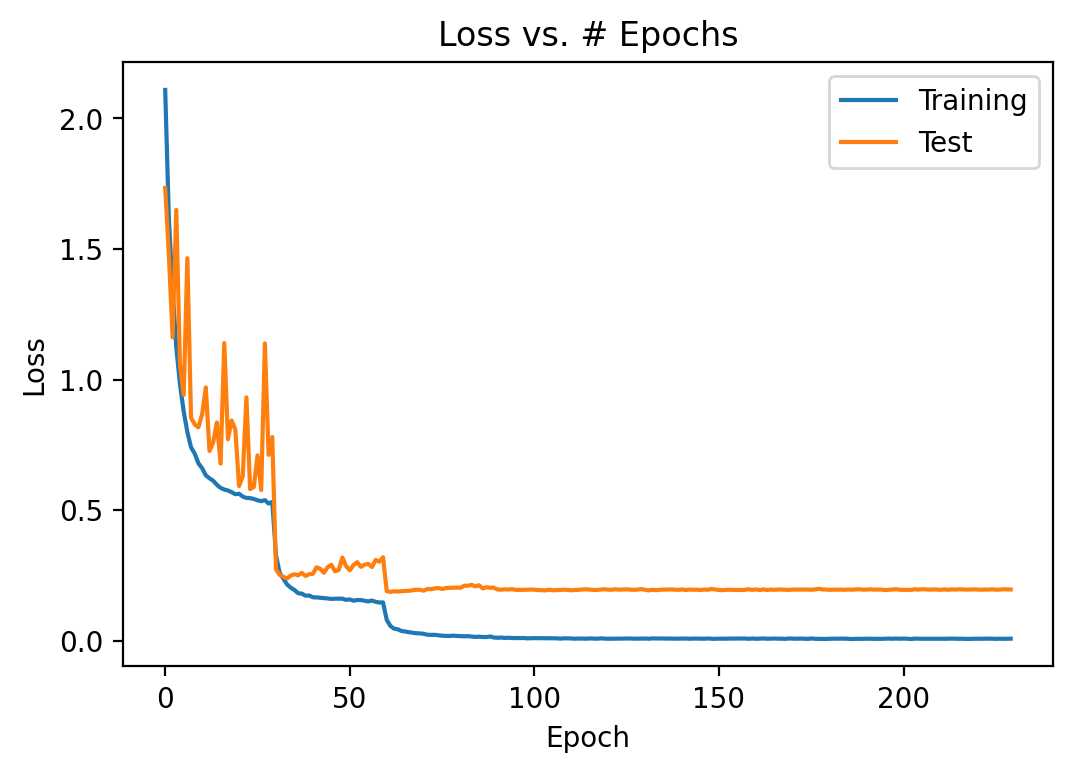

In [15]:
plot_graph(loss_train_plot, loss_test_plot,"Loss")

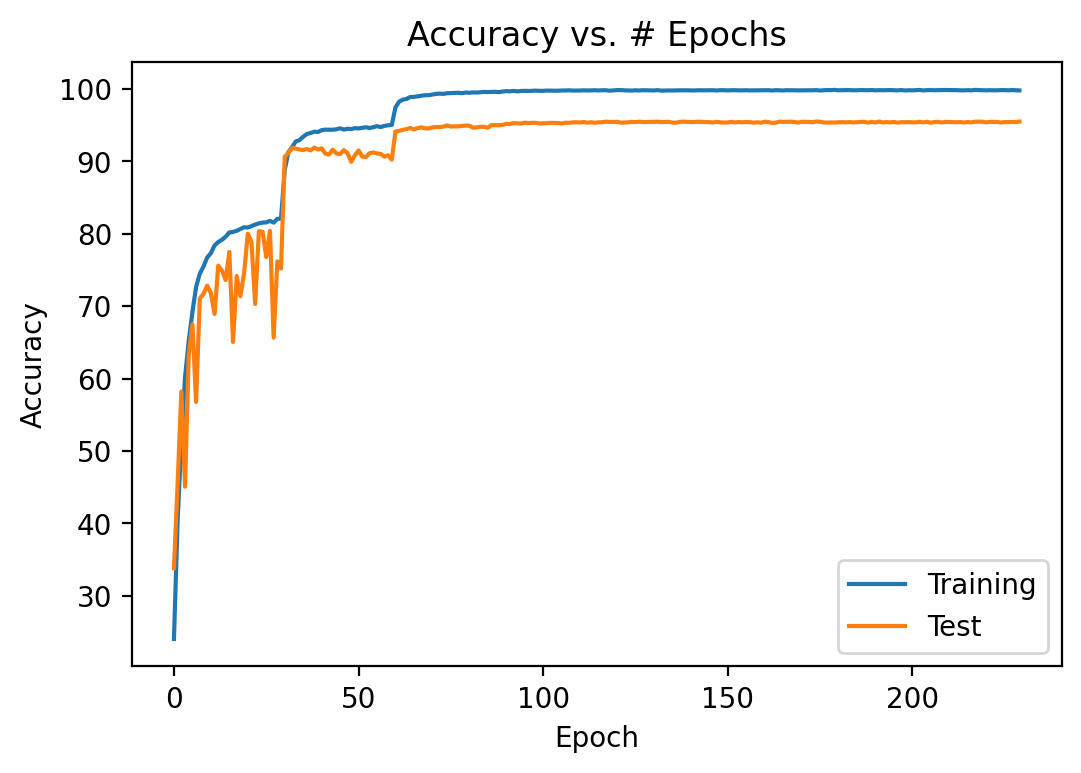

In [16]:
plot_graph(accuracy_train_plot, accuracy_test_plot,"Accuracy")

In [32]:
#loss_train_plota, loss_test_plota,accuracy_train_plota, accuracy_test_plota= torch.load(default_directory+'/tensor(92.5000)tensors.pt')

In [35]:
#plot_graph(accuracy_train_plota, accuracy_test_plota,"Accuracy")